[View in Colaboratory](https://colab.research.google.com/github/giorgianav/workshop-code/blob/master/Feed_forward_nets_for_image_classification.ipynb)

# Feed-forward nets for image classification

## 1. The MNIST dataset

In [1]:
!pip install mnist

In [0]:
#

import mnist
train_imgs = mnist.train_images()
train_labels = mnist.train_labels()
test_imgs = mnist.test_images()
test_labels  = mnist.test_labels()

### Data standardization

Rescale input values to have zero mean and standard deviation of one.

In [0]:
mean, std  = train_imgs.mean(), train_imgs.std()
train_imgs = (train_imgs - mean) / std
test_imgs = (test_imgs - mean) / std

### See some inputs

In [0]:
from typing import List
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Labels: [8 6 3 3 1 4 9 8 0 9 9 2 3 2 6]


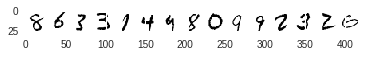

In [5]:
idxs = np.random.randint(0, len(train_imgs), 15)
imgs = np.concatenate(tuple(train_imgs[idx,:,:] for idx in idxs), axis=1)
plt.imshow(imgs)
print("Labels:", train_labels[idxs])

## 2. Building feed forward-networks

### Layers

Each layer will have three methods:
 - `forward` computes and returns ${\bf y}^{(l)} = f_l\left({\bf x}^{(l)}, {\bf w}^{(l)}\right)$
 - `backward` gets $\frac{\partial {\cal L}}{\partial {\bf y}^{(l)}}$, and stores $\frac{\partial {\cal L}}{\partial {\bf w}^{(l)}}$ internally, and returns $\frac{\partial {\cal L}}{\partial {\bf w}^{(l)}}$
 - `update` modifies parameters ${\bf w}^{(l)}$ using stored $\frac{\partial{\cal L}}{\partial{\bf w}}$

In [0]:
class Layer:

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass  # If a layer has no parameters, then this function does nothing

### The feed-forward netowork

In [0]:
class FeedForwardNetwork:
    
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy:np.ndarray) -> np.ndarray:
        # TODO <0> : Compute the backward phase
        for layer, x in zip(self.layers[::-1], self._inputs[::-1]):
            dy = layer.backward(x, dy)
        del self._inputs
    
    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

### The linear layer

In [0]:
class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)

        
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <1> : compute the output of a linear layer
        return x @ self.weight + self.bias
        
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <2> : compute dweight, dbias and  return dx
        self.dweight = x.T @ dy
        self.dbias = dy.sum(axis=0)
        return dy @ self.weight.T
    
    def update(self, mode='SGD', lr=0.001, mu=.9):
        if mode == 'SGD':
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias
        elif mode == 'Nesterov':
            # TODO <9> : compute the nesterov update
            raise NotImplementedError
        elif mode == 'Adam':
            raise NotImplementedError

### The Rectified Linear Unit
$$y = \max\left(x, 0\right)$$

In [0]:
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <3> : Compute the output of a rectified linear unit
        return x * ( x > 0)
        # raise NotImplementedError
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <4> : Compute the gradient w.r.t. x
        return dy * ( x > 0)
        # raise NotImplementedError

## 3. The loss function

   The negative log likelihood combines a softmax activation, and a cross-entropy cost.

In [0]:
class NegativeLogLikelihood:
    
    def __init__(self):
        pass

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        # TODO <5> : Compute the negative log likelihood
        return np.mean(y[np.arange(len(y)),t] - np.log(np.exp(y).sum(axis=1)))
        #raise NotImplementedError
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        # TODO <6> : Compute dl/dy
        toh = np.zeros_like(y)
        toh[np.arange(len(t)), t] = 1
        return (y - toh) / y.shape[0]
        #raise NotImplementedError

### Accuracy

In [0]:
def accuracy(y: np.ndarray, t: np.ndarray) -> float:
    # TODO <7> : Compute accuracy
    return np.mean(t == y.argmax(axis=1)) * 100
    # raise NotImplementedError

## 4. Training a neural network

In [15]:
BATCH_SIZE = 128
HIDDEN_UNITS = 200
EPOCHS_NO = 50

optimize_args = {'mode': 'SGD', 'lr': .001}

net = FeedForwardNetwork([Linear(784, HIDDEN_UNITS),
                          ReLU(),
                          Linear(HIDDEN_UNITS, 10)])

nll = NegativeLogLikelihood()

for epoch in range(EPOCHS_NO):
    for b_no, idx in enumerate(range(0, len(train_imgs), BATCH_SIZE)):
        # 1. Prepare next batch
        x = train_imgs[idx:idx + BATCH_SIZE,:,:].reshape(-1, 784)
        t = train_labels[idx:idx + BATCH_SIZE]
        
        # 2. Compute gradient
        
        # TODO <8> : Compute gradient
        #raise NotImplementedError
        y = net.forward(x)
        loss = nll.forward(y, t)
        dy = nll.backward(y, t)
        net.backward(dy)
        
        # 3. Update network parameters
        net.update(**optimize_args)
        
        print(f'\rEpoch {epoch + 1:02d} '
              f'| Batch {b_no:03d} '
              f'| Train NLL: {loss:3.5f} '
              f'| Train Accuracy: {accuracy(y, t):3.2f} ', end='')

    y = net.forward(test_imgs.reshape(-1, 784), train=False)
    test_nll = nll.forward(y, test_labels)
    print(f' | Test NLL: {test_nll:3.5f} '
          f' | Test Accuracy: {accuracy(y, test_labels):3.2f}')

Epoch 01 | Batch 468 | Train NLL: -2.01516 | Train Accuracy: 35.42  | Test NLL: -1.90825  | Test Accuracy: 47.95
Epoch 02 | Batch 468 | Train NLL: -1.94187 | Train Accuracy: 45.83  | Test NLL: -1.85831  | Test Accuracy: 58.82
Epoch 03 | Batch 468 | Train NLL: -1.90807 | Train Accuracy: 52.08  | Test NLL: -1.83698  | Test Accuracy: 65.42
Epoch 04 | Batch 468 | Train NLL: -1.88622 | Train Accuracy: 60.42  | Test NLL: -1.82514  | Test Accuracy: 69.93
Epoch 05 | Batch 468 | Train NLL: -1.87142 | Train Accuracy: 62.50  | Test NLL: -1.81736  | Test Accuracy: 73.35
Epoch 06 | Batch 468 | Train NLL: -1.85905 | Train Accuracy: 65.62  | Test NLL: -1.81119  | Test Accuracy: 76.12
Epoch 07 | Batch 468 | Train NLL: -1.84763 | Train Accuracy: 69.79  | Test NLL: -1.80568  | Test Accuracy: 77.85
Epoch 08 | Batch 468 | Train NLL: -1.83804 | Train Accuracy: 73.96  | Test NLL: -1.80025  | Test Accuracy: 79.49
Epoch 09 | Batch 468 | Train NLL: -1.82986 | Train Accuracy: 77.08  | Test NLL: -1.79485  | Test